<a href="https://colab.research.google.com/github/KatyBlumer/Cornell-Conversational-Analysis-Toolkit/blob/master/CS_6421_HW_1_Katy_Blumer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and utilities

In [0]:
#@title Imports

# Use venv_ckit, where convokit and spacy are installed
import os
import sys
sys.path.append(f"{os.getcwd()}/venv_ckit/lib/python3.7/site-packages")
sys.path

from convokit.politeness_api.features.politeness_strategies import get_politeness_strategy_features
from itertools import chain
import spacy

from IPython.display import display as disp

import collections
import datetime
import glob
import itertools
import json
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import random
import re
import requests
import seaborn as sns
import sklearn
import sys
import time


# Turn off SettingWithCopyWarning
pd.set_option('mode.chained_assignment', None)
sns.set_style('white')

plt.rcParams['font.size'] = 16
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['figure.titlesize'] = 'large'



DAY_SECS = 86400

perspective_models = [
  # https://github.com/conversationai/perspectiveapi/blob/master/2-api/models.md
                  'TOXICITY',
                  'SEVERE_TOXICITY',
                  "IDENTITY_ATTACK",
                  "INSULT",
                  "PROFANITY",
                  "THREAT",
                  "SEXUALLY_EXPLICIT",
                  "FLIRTATION",

                  # NYT models
                  "ATTACK_ON_AUTHOR",
                  "ATTACK_ON_COMMENTER",
                  'INCOHERENT',
                  "INFLAMMATORY",
                  "LIKELY_TO_REJECT",
                  "OBSCENE",
                  "SPAM",
                  "UNSUBSTANTIAL",               
]
politeness_cols = ['polite_1st_person',
 'polite_1st_person_pl.',
 'polite_1st_person_start',
 'polite_2nd_person',
 'polite_2nd_person_start',
 'polite_Apologizing',
 'polite_Deference',
 'polite_Direct_question',
 'polite_Direct_start',
 'polite_Factuality',
 'polite_Gratitude',
 'polite_HASHEDGE',
 'polite_HASNEGATIVE',
 'polite_HASPOSITIVE',
 'polite_Hedges',
 'polite_INDICATIVE',
 'polite_Indirect_(btw)',
 'polite_Indirect_(greeting)',
 'polite_Please',
 'polite_Please_start',
 'polite_SUBJUNCTIVE']

def timestamp_line(s=""):
  return datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S") + " {}".format(s)

In [0]:
#@title Load scores function

def load_scores_type(stem, score_dir, data_dfs, keep_cols, debug):
  def maybe_print(x):
    if debug:
      print(x)

  scores_paths = sorted(glob.glob(f'{score_dir}/{stem}/*.gz'))
  score_patt = re.compile(
      f".*/{stem}-shard_([0-9]+)-([0-9]+)-([0-9]+).gz")
  
  score_cols = None 

  for path in scores_paths:
    score_match = score_patt.search(path)
    if not score_match:
      continue
    shard_num, start_idx, end_idx = [int(score_match.group(i+1)) for i in range(3)]
    maybe_print(f"Shard: {shard_num}  start_idx: {start_idx}  end_idx: {end_idx}")
    try:
      score_df = pd.read_csv(path)

      new_score_cols = score_df.columns[~score_df.columns.isin(
      ['Unnamed: 0'] + list(data_dfs[0].columns)
          )]
      if len(new_score_cols):
        score_cols = new_score_cols
        for k in data_dfs.keys():
          for score_col in score_cols:
            data_dfs[k][score_col] = np.nan
      

    except:
      print(f"WARNING: skipping slice (probably overwritten by pipeline) {path}")
      continue # prob overwritten

    
    compare_col = ('created_utc' if 'created_utc' in keep_cols else 'subreddit')
    try:
      assert (
          score_df[compare_col] == 
          data_dfs[shard_num].loc[start_idx:end_idx-1].reset_index()[compare_col]
          ).all()
    except:
      print(f"WARNING: skipping path {path}, dfs don't match \n"
            f"Length data df: {data_dfs[shard_num].index[0]}-{data_dfs[shard_num].index[-1]}, "
            f"Length score df:{score_df.index[0]}-{score_df.index[-1]}")
      continue

    
    for score_col in score_cols:
      data_dfs[shard_num].loc[start_idx:end_idx-1, score_col] = score_df[score_col].tolist()

    maybe_print("{:02f} % of shard {} is now missing scores; {}% of current score df is (total len {}).".format(
        data_dfs[shard_num][score_cols[0]].isna().mean() * 100,
        shard_num,
        score_df[score_cols[0]].isna().mean() * 100,
        len(score_df)
        ))
    maybe_print('')


  for shard_num in data_dfs.keys():
    print("{:02f}% of shard {} is still missing scores for {}.".format(
        data_dfs[shard_num][score_cols[0]].isna().mean() * 100,
        shard_num, 
        score_dir
    ))

  return data_dfs

  

def load_gzipped_scores_and_data(stem, keep_cols = ['author', 'subreddit', 'created_utc'], debug=False):
  def maybe_print(x):
    if debug:
      print(x)
  
  data_paths = sorted(glob.glob(f'cloud_data/text_samples/{stem}/*.gz'))
  
  
  data_patt = re.compile(
      f".*/{stem}-shard_([0-9]+).gz")
  
  data_dfs = collections.OrderedDict()

  for path in data_paths:
    shard_num = int(data_patt.search(path).group(1))
    if path == data_paths[0]:
      maybe_print(f"Original columns: {pd.read_csv(path).columns}")

    data_dfs[shard_num] = pd.read_csv(path)[keep_cols]


  for score_type in ["ckit_politeness_scores", "perspective_scores", ]:  # "ckit_politeness_scores",  DO NOT SUBMIT
    data_dfs = load_scores_type(stem, score_type, data_dfs, keep_cols, debug)

  return pd.concat(data_dfs.values())


# CS 6241

In [0]:
#@title Load data

reload = False #@param

if reload:
  next_1k_subs_df = load_gzipped_scores_and_data(
      'sample_next_1k_subs_1k_posts', keep_cols = ['subreddit', 'body'], debug=False)

comment_df = next_1k_subs_df.dropna().sample(100000, replace=False).reset_index()

comment_df['z_intercept'] = 1
A = comment_df[politeness_cols + ['z_intercept']]
b = comment_df['SEVERE_TOXICITY']

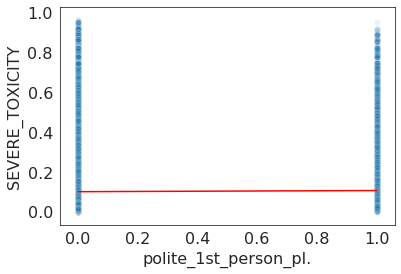

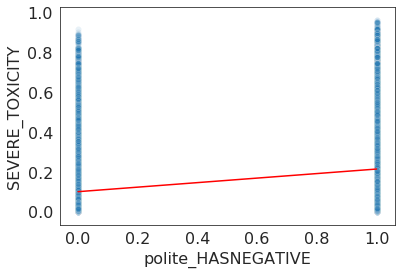

In [0]:
#@title Try with sklearn

model = sklearn.linear_model.LinearRegression()
model = model.fit(A, b)

x_sklearn = list(model.coef_)


for i in [1, np.argmax(np.abs(x_sklearn))]:
  col = politeness_cols[i]
  sns.scatterplot(data=comment_df, x=col, y='SEVERE_TOXICITY', alpha=0.1)
  sns.lineplot([0, 1], [model.intercept_, x_sklearn[i] + model.intercept_], color='r')
  plt.show()


In [0]:
#@title Solving with QR and SVD

def solve_qr(A, b):
  Q, R = np.linalg.qr(A)
  x_QR = np.linalg.inv(R) @ np.transpose(Q) @ b
  return x_QR, Q, R


def solve_svd(A, b):
  U, sig_diag, V = np.linalg.svd(A, full_matrices=False)
  Sig = np.diagflat(sig_diag)

  x_SVD = V @ np.linalg.inv(Sig) @ np.transpose(U) @ np.array(b)
  return x_SVD, U, Sig, V


def solve_svd_L2(A, b, k):
  U, sig_diag, V = np.linalg.svd(A, full_matrices=False)

  U_k = U[:, :k]
  V_k = V[:, :k]
  sig_diag_k_inv = [
                    1/x 
                    for i, x in enumerate(sig_diag) 
                    if (i < k)
                  ]
  Sig_k_inv = np.diagflat(sig_diag_k_inv)

  x_SVD_L2 = V_k @ Sig_k_inv @ np.transpose(U_k) @ b

  return x_SVD_L2


def residual_L2(A, b, x):
  return np.sqrt(np.transpose(A @ x - b) @ (A @ x - b))

x_QR, Q, R = solve_qr(A, b)
x_SVD, U, Sig, V = solve_svd(A, b)

Residual for x_sklearn: 	62.89711801942932
Residual for x_QR: 	54.227688917402254
Residual for x_SVD: 	79.07008010727239
Residual for x_SVD, k=15 (of 22): 	84.30343445998948
Residual for x_SVD, k=5 (of 22): 	75.5458376277539


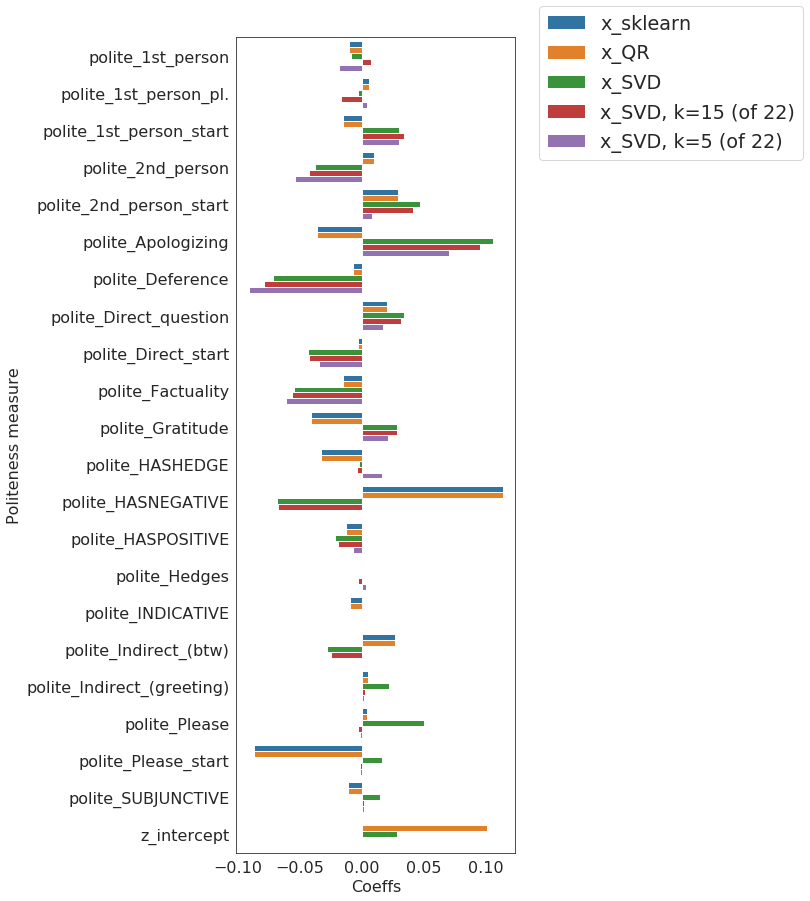

In [0]:
#@title Compare solutions

# Note that x_sklearn uses a separate intercept variable, which is why its z_intercept is 0.

compare_df = pd.DataFrame()
compare_df['Politeness measure'] = politeness_cols+['z_intercept']
compare_df["x_sklearn"] = x_sklearn
compare_df["x_QR"] = x_QR
compare_df["x_SVD"] = x_SVD
compare_df["x_SVD, k=15 (of 22)"] = solve_svd_L2(A, b, 15)
compare_df["x_SVD, k=5 (of 22)"] = solve_svd_L2(A, b, 5)

plot_df = compare_df.melt(id_vars = ['Politeness measure'])
plot_df.columns = ['Politeness measure', 'Method', "Coeffs"]

fig, ax = plt.subplots(figsize=[5, 15])
sns.barplot(data=plot_df, 
            x="Coeffs",
            y='Politeness measure', 
            hue='Method')
ax.legend(bbox_to_anchor=[1.05, 1.05])

for col in compare_df.columns[1:]:
  print(f"Residual for {col}: \t{residual_L2(A, b, list(compare_df[col]))}")

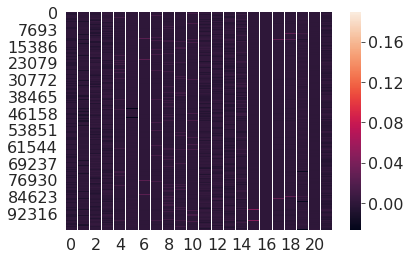

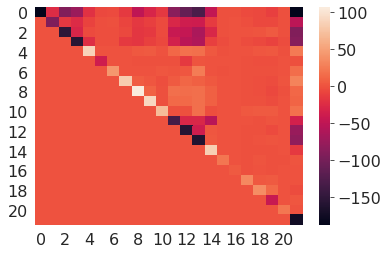

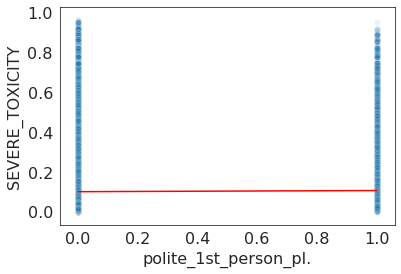

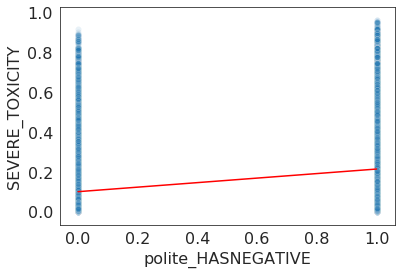

In [0]:
#@title Inspect QR solution

sns.heatmap(Q)
plt.show()
sns.heatmap(R)
plt.show()


for i in [1, np.argmax(np.abs(x_QR))]:
  col = politeness_cols[i]
  sns.scatterplot(data=comment_df, x=col, y='SEVERE_TOXICITY', alpha=0.1)
  sns.lineplot([0, 1], [x_QR[-1], x_QR[i] + x_QR[-1]], color='r')
  plt.show()

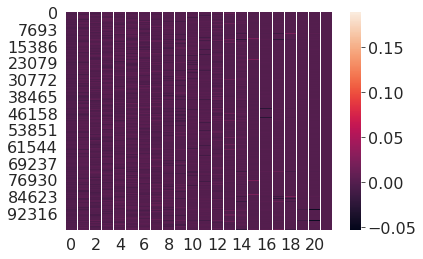

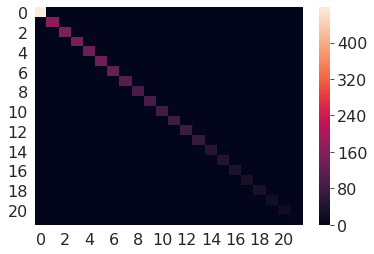

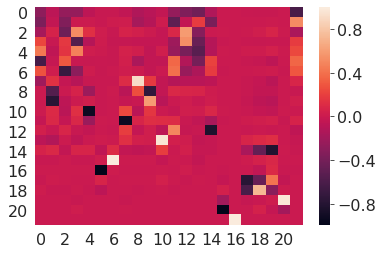

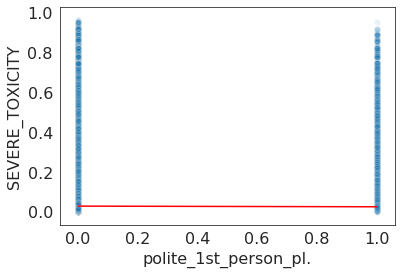

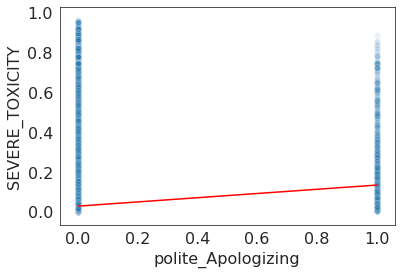

In [0]:
#@title Inspect SVD solution

for mat in [U, Sig, V]:
  sns.heatmap(mat)
  plt.show()


for i in [1, np.argmax(np.abs(x_SVD))]:
  col = politeness_cols[i]
  sns.scatterplot(data=comment_df, x=col, y='SEVERE_TOXICITY', alpha=0.1)
  sns.lineplot([0, 1], [x_SVD[-1], x_SVD[i] + x_SVD[-1]], color='r')
  plt.show()

NameError: ignored

[69.54936162120778, 68.71347632267536, 68.40086875424517, 67.29829781927283, 63.31190553978882, 63.29782331264453, 63.03365996873577, 63.247496724199685, 64.32278924277486, 64.53309254957351, 64.16118948905982, 64.26058231711471, 66.59082571916028, 66.49445619741002, 68.1754348726956, 67.60399546306941, 64.33964711311431, 66.22393960161465, 66.69407962572708, 7763566628365339.0, 8626413454496946.0, 3.133375776851847e+17] 
 [69.54936162120778, 68.71347632267536, 68.40086875424517, 67.29829781927283, 63.31190553978882, 63.29782331264453, 63.03365996873577, 63.247496724199685, 64.32278924277486, 64.53309254957351, 64.16118948905982, 64.26058231711471, 66.59082571916028, 66.49445619741002, 68.1754348726956, 67.60399546306941, 64.33964711311431, 66.22393960161465, 66.69407962572708, 7763566628365339.0, 8626413454496946.0, 3.133375776851847e+17]
[69.95449188018209, 70.5349889497605, 71.6610156950378, 73.81846516802831, 73.77005157354345, 73.60703770993169, 73.5890302051596, 71.45912669942575

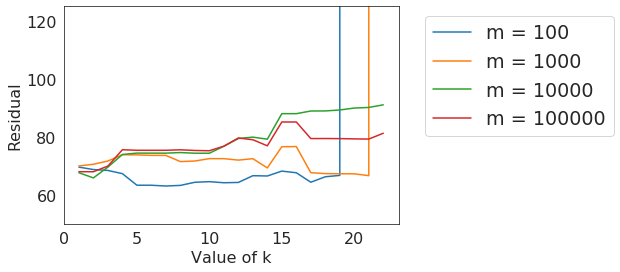

In [0]:
#@title Solve with SVD L2 regularization: throwing out small singular values

def residual_L2(A, b, x):
  return np.sqrt(np.transpose(A @ x - b) @ (A @ x - b))
def residual_L2_TEMP(A, b, x):
  return np.sqrt(np.sum((A @ x - b)**2))


for data_size in [100, 1000, 10000, 100000]:
  residuals = []
  residuals2 = []

  A_small = A.sample(n=data_size, replace=False)
  b_small = list(b.loc[A_small.index])
  for k in range(1, len(A.columns)+1):
    res = residual_L2(A, b, solve_svd_L2(A_small, b_small, k))
    residuals.append(res)
    residuals2.append(residual_L2(A, b, solve_svd_L2(A_small, b_small, k)))
  print(residuals, "\n", residuals2)

  sns.lineplot(list(range(1, len(A.columns)+1)), residuals, label=f"m = {data_size}")
plt.xlabel("Value of k")
plt.ylabel("Residual")
# plt.yscale('log')
plt.legend(bbox_to_anchor=[1.05, 1])
plt.ylim([50, 125])
plt.show()


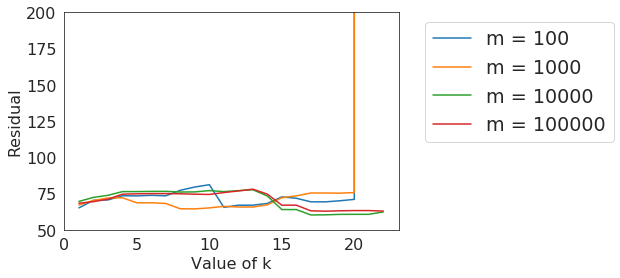

In [0]:
def residual_L2(A, b, x):
  return np.sqrt(np.sum((A @ x - b)**2))


for data_size in [100, 1000, 10000, 100000]:
  residuals = []

  A_small = A.sample(n=data_size, replace=False)
  b_small = list(b.loc[A_small.index])
  for k in range(1, len(A.columns)+1):
    res = residual_L2(A, b, solve_svd_L2(A_small, b_small, k))
    residuals.append(res)

  sns.lineplot(list(range(1, len(A.columns)+1)), residuals, label=f"m = {data_size}")
plt.xlabel("Value of k")
plt.ylabel("Residual")
# plt.yscale('log')
plt.legend(bbox_to_anchor=[1.05, 1])
plt.ylim([50, 200])
plt.show()